## Changes:
  * Look for and then Comment out this line: \#atari.env.render() 
  * If training, in next cell, change 'TRAIN = FALSE' to 'TRAIN = TRUE'

In [1]:
TRAIN = False
#TRAIN = True

ENV_NAME = 'BreakoutDeterministic-v4'
#ENV_NAME = 'PongDeterministic-v4'  
# You can increase the learning rate to 0.00025 in Pong for quicker results

# Deep Q-Learning

Read the introduction to this notebook [here](https://medium.com/@fabiograetz/tutorial-double-deep-q-learning-with-dueling-network-architectures-4c1b3fb7f756)...

... or dive right in :)

The notebook is best viewed in jupyter since github fails to show some $\LaTeX$ formulas properly.

## Contents
1. Reinforcement Learning 
2. Q-Learning
3. Dueling Networks
4. Exploration-exploitation trade-off
5. Replay memory
6. Target network and parameter update
7. Double Q-Learning
8. Putting everything together: DQN
9. Train it yourself
10. Use a trained network


## 1. Reinforcement Learning
In supervised learning a neural network, for instance, learns a function that maps an input to a corresponding output/target on the basis of a large amount of labeled training data consisting of example input-output pairs: Simply put, if you train a neural network to classify, for example, cats and dogs, you repeatedly show the network pictures of cats or dogs, compare the network's prediction to the label and slightly adapt the network's parameters until the neural net is able to classify what animal is shown in a picture.

Now, let's say you let a child play a computer game it has never played before. In the case of [Breakout](https://www.youtube.com/watch?v=TmPfTpjtdgg) the player sees the pixel screen as input and has to decide whether to move left or right. You could certainly show the child many times in which situations it has to press left and in which situations right in order to win the game (supervised learning) but surely the child would become bored quickly and would try to push you aside, wanting to try the game itself. And the child would learn to play the game quickly without being told how to do so simply by evaluating which actions lead to an increased score. In reinforcement learning we try to make a computer learn in this exact same way, by letting it explore the environment and occasionally giving it a reward when the score increases. 

However, in comparison to supervised learning, this poses a problem. On p. 1 of [Mnih et al. 2013](https://arxiv.org/abs/1312.5602) the authors say:

>RL algorithms [...] must be able to learn from a scalar reward signal that is frequently sparse [...] and delayed. The delay between actions and resulting rewards, which can be thousands of timesteps long, seems particularly daunting when compared to the direct association between inputs and targets found in supervised learning.

What do the authors mean with with "sparse [...] and delayed"? 

Imagine you walk through a maze trying to find treasures. You get a reward once you find gold. Now imagine you encounter a fork in the path. Which way do you take? As opposed to supervised learning, at the fork the agent does not get any immediate feedback/reward for taking the right path but only later once it finds any gold. Yet it might have been crucial to take for example the left way at the fork. This is what the authors mean with *delayed*. The problem is met by discounting future rewards with a factor $\gamma$ (between 0 and 1). 

[Sutton and Barto 2018](https://drive.google.com/file/d/1xeUDVGWGUUv1-ccUMAZHJLej2C7aAFWY/view) write on page 55:

>The additional concept that we need is that of discounting. According to this approach,
the agent tries to select actions so that the sum of the discounted rewards it receives over
the future is maximized. In particular, it chooses $A_t$ to maximize the *expected discounted
return*:

The discounted return $G_t$ is calculated as follows  

\begin{align}
G_{t} &= R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + ... \\
&=R_{t+1} + \gamma \bigl(R_{t+2} + \gamma R_{t+3} + ...\bigr)\\
&= R_{t+1} + \gamma G_{t+1}
\end{align}

where $R_t$ is the reward the agent received at time $t$.

The authors furthermore explain:

>a reward received $k$ time steps in the future is worth only $\gamma^{k−1}$ times what it would be worth if it were received immediately.

and

>As $\gamma$ approaches 1, the return objective takes future rewards into account more strongly; the agent becomes more farsighted.

Let us look at a very simple example where there is just one reward not equal to 0 (calculate from right to left):

time $t$ |  0| 1 | 2|3|4|
:---| --- | ---| ---|---|---|
reward sequence $R_t$|  | 0 | 0 | 0 | 1 |
discounted returns $G_t$| $\gamma^3$ | $\gamma^2$ | $\gamma$ | 1 | 0 |
for $\gamma=0.9$|0.729 | 0.81 | 0.9| 1 |0|

Minor detail: In this example there is no reward at $t=0$ because the first reward $R_1$ is a result of action $a_0$ taken in state $s_0$ and the reward is always associated with the next state in Sutton and Barto. Some articles associate the reward $R_i$ with the state $s_i$ and action $a_i$ that caused the reward. In that case the definition of the discounted return changes to $G_t=R_{t} + \gamma G_{t+1}$, in the table the 1's would all be in the same column and there would be a reward equal to 0 at $t=0$ but not at $t=4$ .

Simply put, by discounting returns, future rewards increase past or current returns and the closer $\gamma$ is to 1, the farther the agent can *see* into the future. 

And *sparse*?
In our fictive maze example, the rewards are the sparser, the less gold you find. For an agent, a game is more difficult to learn, the sparser the reward is. [Pong](https://gym.openai.com/envs/Pong-v0/) is one of the games DQN can learn fastest because the score changes quite often. [Montezuma's Revenge](https://gym.openai.com/envs/MontezumaRevenge-v0/), on the other hand, has very sparse rewards and DQN (at least without some additional tricks) is not able to learn the game at all.


## 2. Q-Learning
So how does Q-Learning work? If the agent (regardless if trained or still untrained) is shown a state $s$ of the game, it has to decide which action $a$ to perform (for example move paddle left or right in breakout). How does it do that? On page 2 [Mnih et al. 2013](https://arxiv.org/abs/1312.5602) define the so-called $Q$-Function:
>We define the optimal action-value function $Q^∗(s, a)$ as the maximum expected return achievable by following any strategy, after seeing some sequence $s$ and then taking some action $a$ 

This means that given a state of the game $s$ (for now please consider *sequences* as states of the game), $Q^*(s,a)$ is the best (discounted) total return the agent can achieve if it performs action $a$ in the current state $s$. So how does it choose which action to perform assuming we already know $Q^*(s,a)$? One obvious strategy would be to always choose the action with the maximum value of $Q^*$ (we will see later, why this is slightly problematic). But first of all, we need to find this magical function $Q^*$:

Let's say we are in state $s$, decide to perform action $a$ and arrive in the next state $s'$. If we assume that in state $s'$ the $Q^*$-values for all possible actions $a'$ were already known, then the $Q^*$-value in state $s$ for action $a$ (action-value in $s$ for action $a$) would be the reward $r$ we got for performing action $a$ plus the discounted maximum future return in $s'$:

\begin{equation}
Q^*(s,a) = r + \gamma \textrm{max}\left( Q^*(s',a') \right)
\end{equation}

Less formal but more intuitive:
If we were at a certain fork in the maze (state $s$) and want to know how good it was to choose the left path (perform action $a$), we add the gold we found after going left (reward we received for performing action $a$) and the amount of gold we expect to find down the road (maximum future discounted return). If you have to choose between finding a golden coin immediately after going left at a fork but nothing else down the road or finding nothing immediatley after going right but a treasure down the road, well, the right path is worth more/has a higher action-value.

This is the so-called **Bellman equation**. Deep Q-Learning uses a neural network to find an approximation $Q(s,a,\theta)$ of $Q^*(s,a)$. $\theta$ are the parameters of the neural network. We will discuss later, how exactly the parameters of the network are updated. Now, I will explain to you, how the neural network maps a state $s$ to $Q$-values for the possible actions $a$.

Earlier I mentioned, that I regard a *sequence* as a *state*. What did I mean with that? Imagine you have a pin-sharp image of a flying soccer ball. Can you tell in which direction it moves? No, you cannot, but you could if there was some kind of motion blur in the picture or if you had several images taken quickly one after another showing the ball in a slightly different position every time. The same problem occurs in Atari games. From a single frame of the game [Pong](https://gym.openai.com/envs/Pong-v0/), the agent can not discern in which direction the ball moves. DeepMind met this problem by stacking several consecutive frames and considering this sequence a state that is passed to the neural network. From such a sequence the agent is able to detect the direction and speed of movement because the ball is in a different position in each frame.

>Since the agent only observes images of the current screen [...] it is impossible to fully understand the current situation from only the current screen $x_t$. We therefore consider sequences of actions and observations, $s_t = x_1, a_1, x_2, ..., a_{t−1}, x_t$, and learn game strategies that depend upon these sequences. All sequences in the emulator are assumed to terminate in a finite number of time-steps. This formalism gives rise to a large but finite Markov decision process (MDP) in which each sequence is a distinct state. ([page 2 of Mnih et al. 2013](https://arxiv.org/abs/1312.5602))

You should defenitely understand what a [Markov decision process](https://en.wikipedia.org/wiki/Markov_decision_process) and a [Markov chain
](https://en.wikipedia.org/wiki/Markov_chain) is, they are fundamental to reinforcement learning. 

On page 5 of [Mnih et al. 2013](https://arxiv.org/abs/1312.5602) the authors explain the preprocessing of the frames:

>Working directly with raw Atari frames, which are 210 × 160 pixel images with a 128 color palette, can be computationally demanding, so we apply a basic preprocessing step aimed at reducing the input dimensionality. The raw frames are preprocessed by first converting their RGB representation to gray-scale and down-sampling it to a 110×84 image. The final input representation is obtained by cropping an 84 × 84 region of the image that roughly captures the playing area. The final cropping stage is only required because we use the GPU implementation of 2D convolutions from [...], which expects square inputs. For the experiments in this paper, the function $\phi$ [...] applies this preprocessing to the last 4 frames of a history and stacks them to produce the input to the $Q$-function.

So let us start by looking at how the preprocessing can be implemented. I used `gym` from OpenAi to provide the environment. A frame returned by the environment has the shape `(210,160,3)` where the 3 stands for the RGB color channels. Such a frame is passed to the Functor`FrameProcessor` which transforms it to a `(84,84,1)` frame, where the 1 indicates that instead of three RGB channels there is one grayscale channel. 


In [2]:
"""
Implementation of DeepMind's Deep Q-Learning by Fabio M. Graetz, 2018
If you have questions or suggestions, write me a mail fabiograetzatgooglemaildotcom
"""
import os
import random
import gym
import tensorflow as tf
import numpy as np
import imageio
from skimage.transform import resize
from IPython.display import Image

In [3]:
class FrameProcessor(object):
    """Resizes and converts RGB Atari frames to grayscale"""
    def __init__(self, frame_height=84, frame_width=84):
        """
        Args:
            frame_height: Integer, Height of a frame of an Atari game
            frame_width: Integer, Width of a frame of an Atari game
        """
        self.frame_height = frame_height
        self.frame_width = frame_width
        self.frame = tf.placeholder(shape=[210, 160, 3], dtype=tf.uint8)
        self.processed = tf.image.rgb_to_grayscale(self.frame)
        self.processed = tf.image.crop_to_bounding_box(self.processed, 34, 0, 160, 160)
        self.processed = tf.image.resize_images(self.processed, 
                                                [self.frame_height, self.frame_width], 
                                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    def __call__(self, session, frame):
        """
        Args:
            session: A Tensorflow session object
            frame: A (210, 160, 3) frame of an Atari game in RGB
        Returns:
            A processed (84, 84, 1) frame in grayscale
        """
        return session.run(self.processed, feed_dict={self.frame:frame})

## 3. Dueling Networks

Instead of the network architecture described in [Mnih et al. 2013](https://arxiv.org/abs/1312.5602) or [Mnih et al. 2015](https://www.nature.com/articles/nature14236/) I used the dueling network architecture described in [Wang et al. 2016](https://arxiv.org/abs/1511.06581).

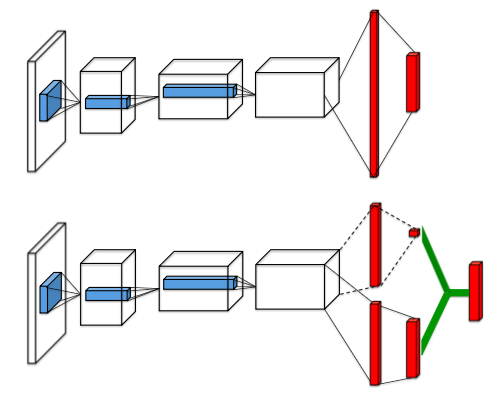

In [4]:
PATH = "pictures/"
Image(filename = PATH + "dueling.png", width=400, height=400)




![](pictures/dueling.png "Figure 1 in Wang et al. 2016")

Both the [Mnih et al. 2015](https://www.nature.com/articles/nature14236/) and the [Wang et al. 2016](https://arxiv.org/abs/1511.06581) dueling architecture have the same low-level convolutional structure:

>The first convolutional layer has 32 8x8 filters with stride 4, the second 64 4x4 filters with stride 2, and the third and final convolutional layer consists 64 3x3 filters with stride 1.

In the normal DQN architecture (top network in the figure) the *final hidden layer is fully-connected and consists of 512 rectifier units. The output layer is a fully-connected linear layer with a single output for each valid action.* (see page 6 of [Mnih et al. 2015](https://www.nature.com/articles/nature14236/)) 

These outputs are the predicted $Q(s,a;\theta)$-values for action $a$ in state $s$.

Instead of directly predicting a single $Q$-value for each action, the dueling architecture splits the final convolutional layer into two streams that represent the value and advantage functions that predict a *state value* $V(s)$ that depends only on the state, and *action advantages* $A(s,a)$ that depend on the state and the respective action. On page 2 of [Wang et al. 2016](https://arxiv.org/abs/1511.06581) the authors explain:

>Intuitively, the dueling architecture can learn which states are (or are not) valuable, without having to learn the effect of each action for each state. This is particularly useful in states where its actions do not affect the environment in any relevant way. 
In the experiments, we demonstrate that the dueling architecture can more quickly identify the correct action during policy evaluation as redundant or similar actions are added to the learning problem. 

The *state value* $V(s)$ predicts *how good it is to be in a certain state* $s$ and the *action advantage* $A(s,a)$ predicts *how good it is to perform action $a$ in state $s$*.
I suggest you take a look at figure 2 in [Wang et al. 2016](https://arxiv.org/abs/1511.06581) to better understand what the value- and advantage-stream learn to look at.

Next, we have to combine the value and advantage stream into $Q$-values $Q(s,a)$. This is done the following way (equation 9 in [Wang et al. 2016](https://arxiv.org/abs/1511.06581)):

\begin{equation}
Q(s,a) = V(s) + \left(A(s,a) - \frac 1{| \mathcal A |}\sum_{a'}A(s, a')\right)
\end{equation}

Why so complicated instead of just adding $V(s)$ and $A(s,a)$? Let's assume $Q(s,a) = V(s) + A(s,a)$:

 The Q function measures the value of choosing a particular action when in a particular state. The value function $V$, which is the expected value of $Q$ over all possible actions, $V = E(Q)$, measures how good it is to be in this particular state. 

If you combine $E(Q) = V$ and $Q = V + A$, you find $E(Q) = E(V) + E(A)$. But $V$ does not depend on any action, which means $E(V)=V$, $E(Q) = V + E(A) = V$ and thus $E(A)=0$. The expected value of the advantage $A(s,a')$ over all possible actions $a'$ has to be zero. The expected value of the expression in parentheses is zero because we subtract the mean of the advantages from every advantage:

\begin{equation}
E\left(A(s,a) - \frac 1{| \mathcal A |}\sum_{a'}A(s, a')\right) = E\Bigl(A - E(A)\Bigr) = E(A)- E(E(A)) = E(A) - E(A) = 0
\end{equation}

In the cell below you find the code that implements this architecture in tensorflow. Some things to keep in mind: You should normalize the input pixel values to [0,1] by dividing the input with 0xFF=255. The reason for this is, that the pixel values of the frames, the environment returns, are uint8 which can store values in the range [0,255]. 

**Furthermore, make sure you initialize the weights properly! 
The DQN uses the Relu activation function and the right initializer is [He et al. 2015 equation 10](https://arxiv.org/pdf/1502.01852v1.pdf) ([click here for a detailed explanation](https://www.youtube.com/watch?v=s2coXdufOzE&t=157s )).
In tensorflow use `tf.variance_scaling_initializer` [(documentation)](https://www.tensorflow.org/api_docs/python/tf/variance_scaling_initializer) with `scale = 2`.**

DeepMind used an implementation of the RMSProp optimizer that is different to the one in tensorflow (see page 23, eq 40 in [Graves 2014](https://arxiv.org/pdf/1308.0850v5.pdf)). Before implementing it myself, I tried the Adam optimizer which gave promising results without much hyperparameter-search. Adam was not invented when [Mnih et al. 2013](https://arxiv.org/abs/1312.5602) was published, so one could argue that they might have used it instead of RMSProp if it had been invented earlier. On the other hand, the authors of this [blog post](https://blog.paperspace.com/intro-to-optimization-momentum-rmsprop-adam/) compare *Momentum, RMSProp and Adam* and argue:
>Out of the above three, you may find momentum to be the most prevalent, despite Adam looking the most promising on paper. Empirical results have shown that all these algorithms can converge to different optimal local minima given the same loss. However, SGD with momentum seems to find more flatter minima than Adam, while adaptive methods tend to converge quickly towards sharper minima. Flatter minima generalize better than sharper ones.

Maybe some of these differences might be mitigated by the use of *AdamW*, which I described [in this blog post](https://medium.com/@fabiograetz/why-adamw-matters-736223f31b5d) (irrelevant for DQN since no regularization is used). For now, I stick with Adam and if I find some time in the future, I might come back to this since it might be well worth spending some time on playing with different optimizers and implementing the version of RMSProp used by DeepMind. 

*Edit*: In a later DeepMind paper called "Rainbow: Combining Improvements in Deep Reinforcement Learning" by [Hessel et al. 2017](https://arxiv.org/abs/1710.02298) RMSProp was substituted for Adam with a learning rate of 0.0000625 (see Table 1). This learning rate is close to what I found working well for Breakout (0.00001) before reading Hessel et al. 2017.

If you compare the dueling architecture described above to the network implemented in the next cell, you will find a small difference. Instead of two hidden fully connected layers with 512 rectifier units for each, the value and the advantage stream, I ended up adding a fourth convolutional layer with 1024 filters. The output has the shape (1, 1, 1024) and is then split into two streams with shapes (1, 1, 512). This architecture is suggested [here](https://github.com/awjuliani/DeepRL-Agents/blob/master/Double-Dueling-DQN.ipynb) and after performing some tests on the environment Pong, which is comparably easy to learn for a DQN agent, I find that this small adjustment lets the reward increase slightly earlier and higher.

In [5]:
class DQN(object):
    """Implements a Deep Q Network"""
    
    # pylint: disable=too-many-instance-attributes
    
    def __init__(self, n_actions, hidden=1024, learning_rate=0.00001, 
                 frame_height=84, frame_width=84, agent_history_length=4):
        """
        Args:
            n_actions: Integer, number of possible actions
            hidden: Integer, Number of filters in the final convolutional layer. 
                    This is different from the DeepMind implementation
            learning_rate: Float, Learning rate for the Adam optimizer
            frame_height: Integer, Height of a frame of an Atari game
            frame_width: Integer, Width of a frame of an Atari game
            agent_history_length: Integer, Number of frames stacked together to create a state
        """
        self.n_actions = n_actions
        self.hidden = hidden
        self.learning_rate = learning_rate
        self.frame_height = frame_height
        self.frame_width = frame_width
        self.agent_history_length = agent_history_length
        
        self.input = tf.placeholder(shape=[None, self.frame_height, 
                                           self.frame_width, self.agent_history_length], 
                                    dtype=tf.float32)
        # Normalizing the input
        self.inputscaled = self.input/255
        
        # Convolutional layers
        self.conv1 = tf.layers.conv2d(
            inputs=self.inputscaled, filters=32, kernel_size=[8, 8], strides=4,
            kernel_initializer=tf.variance_scaling_initializer(scale=2),
            padding="valid", activation=tf.nn.relu, use_bias=False, name='conv1')
        self.conv2 = tf.layers.conv2d(
            inputs=self.conv1, filters=64, kernel_size=[4, 4], strides=2, 
            kernel_initializer=tf.variance_scaling_initializer(scale=2),
            padding="valid", activation=tf.nn.relu, use_bias=False, name='conv2')
        self.conv3 = tf.layers.conv2d(
            inputs=self.conv2, filters=64, kernel_size=[3, 3], strides=1, 
            kernel_initializer=tf.variance_scaling_initializer(scale=2),
            padding="valid", activation=tf.nn.relu, use_bias=False, name='conv3')
        self.conv4 = tf.layers.conv2d(
            inputs=self.conv3, filters=hidden, kernel_size=[7, 7], strides=1, 
            kernel_initializer=tf.variance_scaling_initializer(scale=2),
            padding="valid", activation=tf.nn.relu, use_bias=False, name='conv4')
        
        # Splitting into value and advantage stream
        self.valuestream, self.advantagestream = tf.split(self.conv4, 2, 3)
        self.valuestream = tf.layers.flatten(self.valuestream)
        self.advantagestream = tf.layers.flatten(self.advantagestream)
        self.advantage = tf.layers.dense(
            inputs=self.advantagestream, units=self.n_actions,
            kernel_initializer=tf.variance_scaling_initializer(scale=2), name="advantage")
        self.value = tf.layers.dense(
            inputs=self.valuestream, units=1, 
            kernel_initializer=tf.variance_scaling_initializer(scale=2), name='value')
        
        # Combining value and advantage into Q-values as described above
        self.q_values = self.value + tf.subtract(self.advantage, tf.reduce_mean(self.advantage, axis=1, keepdims=True))
        self.best_action = tf.argmax(self.q_values, 1)
        
        # The next lines perform the parameter update. This will be explained in detail later.
        
        # targetQ according to Bellman equation: 
        # Q = r + gamma*max Q', calculated in the function learn()
        self.target_q = tf.placeholder(shape=[None], dtype=tf.float32)
        # Action that was performed
        self.action = tf.placeholder(shape=[None], dtype=tf.int32)
        # Q value of the action that was performed
        self.Q = tf.reduce_sum(tf.multiply(self.q_values, tf.one_hot(self.action, self.n_actions, dtype=tf.float32)), axis=1)
        
        # Parameter updates
        self.loss = tf.reduce_mean(tf.losses.huber_loss(labels=self.target_q, predictions=self.Q))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.update = self.optimizer.minimize(self.loss)

One other interesting thing to notice: DeepMind uses the quadratic cost function with error clipping (see page 7 of [Mnih et al. 2015](https://www.nature.com/articles/nature14236/)).

>We also found it helpful to clip the error term from the update [...] to be between -1 and 1. Because the absolute value loss function |x| has a derivative of -1 for all negative values of x and a derivative of 1 for all positive values of x, clipping the squared error to be between -1 and 1 corresponds to using an absolute value loss function for errors outside of the (-1,1) interval. This form of error clipping further improved the stability of the algorithm.

Why does this improve the stability of the algorithm?

>In deep networks or recurrent neural networks, error gradients can accumulate during an update and result in very large gradients. These in turn result in large updates to the network weights, and in turn, an unstable network. At an extreme, the values of weights can become so large as to overflow and result in NaN values. [Source](https://machinelearningmastery.com/exploding-gradients-in-neural-networks/)

This so-called exploding gradient problem can, to some extent, be avoided by clipping the gradients to a certain threshold value, if they exceed it: * If the true gradient is larger than a critical value $x$, just assume it is $x$.* Observe that the derivate of the green curve does not increase (or decrease) for $x>1$ (or $x<-1$).
Error clipping can be easily implemented in tensorflow by using the Huber loss function `tf.losses.huber_loss`.



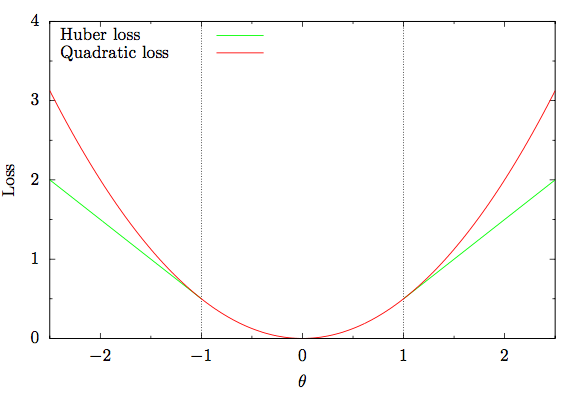

In [6]:
PATH = "pictures/"
Image(filename = PATH + "huber.png", width=600, height=600)

![](pictures/huber.png)

Sidenote: If you are interested in creating high quality plots for publications in the eps format (vector) using LaTeX for labels, annotations or even formulas, check the gnuplot scripts in the pictures folder.



## 4. Exploration-exploitation trade-off
If you look at the code in the previous cell, you will find, that we are now able to predict the action, the network considers best (`self.best_action`) by taking the argument of the maximum $Q$-value. But initially, the agent does not know how to play the game. If we always exploit and never explore by always choosing the action with the highest $Q$-value (greedy), the agent will stick to the first strategy it discovers that returns a small reward. It can then not continue exploring the environment and can not continue to learn. The $\epsilon$-greedy algorithm offers a simple solution for that problem: Simply put, we usually choose the action the networks deems best but with a probability of $\epsilon$ we choose a random action. $\epsilon$ is a function of the number of frames the agent has seen. For the first 50000 frames the agent only explores ($\epsilon=1$). Over the following 1 million frames, $\epsilon$ is linearly decreased to 0.1, meaning that the agent starts exploiting more and more. DeepMind then keeps $\epsilon=0.1$, however, we chose to decrease it to $\epsilon=0.01$ over the remaining frames as suggested by the [OpenAi Baselines for DQN](https://blog.openai.com/openai-baselines-dqn/) (in the plot the maximum number of frames is 2 million for demonstration purposes).

![](pictures/epsilon.png "See the gnuplot script in the pictures folder to find out how to quickly create this plot")



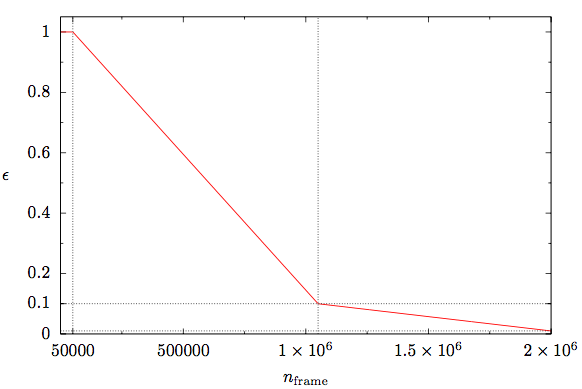

In [7]:
PATH = "pictures/"
Image(filename = PATH + "epsilon.png", width=600, height=600)

The method `get_action` in the cell below implements this behaviour: It first calculates $\epsilon$ from the number of the current frame and then either returns a random action (with probability $\epsilon$) or the action the DQN deems best. The variables in the constructor are the slopes and intercepts for the decrease of $\epsilon$ shown in the plot above.

In [8]:
class ExplorationExploitationScheduler(object):
    """Determines an action according to an epsilon greedy strategy with annealing epsilon"""
    def __init__(self, DQN, n_actions, eps_initial=1, eps_final=0.1, eps_final_frame=0.01, 
                 eps_evaluation=0.0, eps_annealing_frames=1000000, 
                 replay_memory_start_size=50000, max_frames=25000000):
        """
        Args:
            DQN: A DQN object
            n_actions: Integer, number of possible actions
            eps_initial: Float, Exploration probability for the first 
                replay_memory_start_size frames
            eps_final: Float, Exploration probability after 
                replay_memory_start_size + eps_annealing_frames frames
            eps_final_frame: Float, Exploration probability after max_frames frames
            eps_evaluation: Float, Exploration probability during evaluation
            eps_annealing_frames: Int, Number of frames over which the 
                exploration probabilty is annealed from eps_initial to eps_final
            replay_memory_start_size: Integer, Number of frames during 
                which the agent only explores
            max_frames: Integer, Total number of frames shown to the agent
        """
        self.n_actions = n_actions
        self.eps_initial = eps_initial
        self.eps_final = eps_final
        self.eps_final_frame = eps_final_frame
        self.eps_evaluation = eps_evaluation
        self.eps_annealing_frames = eps_annealing_frames
        self.replay_memory_start_size = replay_memory_start_size
        self.max_frames = max_frames
        
        # Slopes and intercepts for exploration decrease
        self.slope = -(self.eps_initial - self.eps_final)/self.eps_annealing_frames
        self.intercept = self.eps_initial - self.slope*self.replay_memory_start_size
        self.slope_2 = -(self.eps_final - self.eps_final_frame)/(self.max_frames - self.eps_annealing_frames - self.replay_memory_start_size)
        self.intercept_2 = self.eps_final_frame - self.slope_2*self.max_frames
        
        self.DQN = DQN

    def get_action(self, session, frame_number, state, evaluation=False):
        """
        Args:
            session: A tensorflow session object
            frame_number: Integer, number of the current frame
            state: A (84, 84, 4) sequence of frames of an Atari game in grayscale
            evaluation: A boolean saying whether the agent is being evaluated
        Returns:
            An integer between 0 and n_actions - 1 determining the action the agent perfoms next
        """
        if evaluation:
            eps = self.eps_evaluation
        elif frame_number < self.replay_memory_start_size:
            eps = self.eps_initial
        elif frame_number >= self.replay_memory_start_size and frame_number < self.replay_memory_start_size + self.eps_annealing_frames:
            eps = self.slope*frame_number + self.intercept
        elif frame_number >= self.replay_memory_start_size + self.eps_annealing_frames:
            eps = self.slope_2*frame_number + self.intercept_2
        
        if np.random.rand(1) < eps:
            return np.random.randint(0, self.n_actions)
        return session.run(self.DQN.best_action, feed_dict={self.DQN.input:[state]})[0]  

We now know how the DQN predicts the best action and we have a simple answer to the exploration exploitation dilemma.
So, what else do we need to make it work? Let's take a look at the algorithm presented on page 7 in [Mnih et al. 2015](https://www.nature.com/articles/nature14236/).

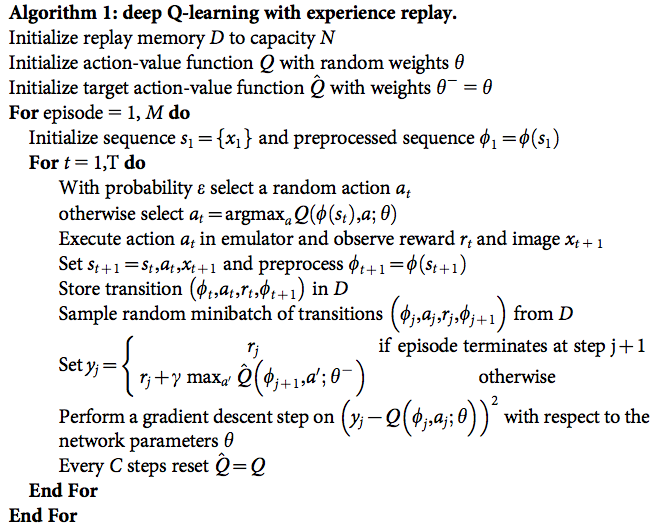

In [9]:
PATH = "pictures/"
Image(filename = PATH + "DQN.png", width=600, height=600)



![](pictures/DQN.png)

Let us go through the algorithm step by step:
* We do not know yet what *replay memory* D is.
* Action-value function Q is our DQN network, that we already implemented.
* We need to discuss why a second Q network called *target* action-value function is needed.
* At the beginning of each episode a sequence is initalized. This is implemented by stacking four (grayscale) frames together as discussed above.
* We discussed how the action is selected ($\epsilon$-greedy).
* When the action is performed, the environment returns the next frame and the reward for that action. `gym` additionaly returns a boolean called `terminal` that states whether the game is over and a dictionary containing the number of lives the agent has left (`ale.lives`). 
* We do not know yet, what it means to store a transition in the replay memory D. A list `[state, action, reward, terminal, new_state]` is called transition. A `state` are four frames stacked together. `new_state` is produced by stacking the observed frame (after the action is performed) onto `state` and removing the oldest frame. You will see the implementation later. 
* We have to discuss, how a minibatch is retured from the replay memory and how the gradient descend step is performed.
* Finally we have to look at why and how the target Q network is reset to the main Q network.

Let's continue with the replay memory

## 5. Replay memory

>Second, learning directly from consecutive samples is inefficient, due to the strong correlations between the samples; randomizing the samples breaks these correlations and therefore reduces the variance of the updates. Third, when learning on-policy the current parameters determine the next data sample that the parameters are trained on. For example, if the maximizing action is to move left then the training samples will be dominated by samples from the left-hand side; if the maximizing action then switches to the right then the training distribution will also switch. It is easy to see how unwanted feedback loops may arise and the parameters could get stuck in a poor local minimum, or even diverge catastrophically. ([page 5 of Mnih et al. 2013](https://arxiv.org/abs/1312.5602))

This means that when we choose an action and perform a step to receive a reward, the network does not learn from this last step but rather adds the transition to the replay memory. It then draws a random minibatch from the replay memory to perform a gradient descent step.

The replay memory stores the last one million transitions. Let's recall that a transition is `[state, action, reward, terminal, new_state]`. We therefore need to store the last one million `state`, `action`, `reward`, `terminal` and `new_state`. If you remember that `state` and `new_state` are four frames each, that would be eight million frames. However, since `new_state` is created by stacking the newest frame on top of `state` and deleting the oldest frame, `new_state` and `state` share three frames. Furthermore, `new_state` of transition i will be `state` of transition i+1. This means that it is sufficient to store the last one million frames (84*84 pixels) as a (1 million, 84, 84) tensor and then slicing four frames out of this tensor when we need a `state` or `new_state`. 

With one million frames of 84 by 84 pixels that need to be stored in your computers memory, we need to consider in what datatype we store them. The environment returns frames with pixel values stored as `uint8` which can have values ranging from 0 to 255. A `uint8` needs 8 bits. The network expects a `tf.float32` input with pixel values between 0 and 1 (which takes four times more space than a `uint8`). Since we want to reduce the memory requirements, we store the frames in `uint8` and divide them by 255 before passing them to the network.

When implementing this version of replay memory, we looked at this [code](https://github.com/tambetm/simple_dqn/blob/master/src/replay_memory.py) and ended up implementing the replay memory with some adjustments that make the code more understandable.

Let's look at the `ReplayMemory` class below. In the constructor, we pre-allocate the memory for the frames, the actions, the rewards, the terminal states and also for the states and new states of the minibatch. 

In the `add_experience` method the frames etc. are written into `self.frames` at index `self.current` which is then increased by 1. When `self.current` reaches the size of the replay memory (one million), it is reset to zero to overwrite the oldest frames. The method `_get_state` slices four frames out of `self.frames` and returns them as a `state`.

To understand what the method `_get_valid_indices` does, we need to understand what an invalid index is. We store all frames the agent sees in `self.frames`. When a game terminates (`terminal=True`) at index i, frame at index i belongs to a different episode than the frame at i+1. We want to avoid creating a `state` with frames from two different episodes. The same thing can happen at the index `self.current`. 

Finally we need to make sure that an index is not smaller than the number of frames stacked toghether to create a `state` (`self.agent_history_length=4`), so that a `state` and `new_state` can be sliced out of the array. 

The method `_get_valid_indices` finds 32 (size of minibatch) valid indices.
The method `get_minibatch` returns the transitions for those indices. Pay attention that we need to transpose `self.states` and `self.new_states` before returning them: the DQN expects an input of the dimension `[None,84,84,4]` whereas `_get_state` returns a `state` of the dimension `[4,84,84]`

We now know 1) why a replay memory greatly improves the stability of the algorithm, 2) how to store a transition in the replay memory and 3) how a minibatch is returned.


In [10]:
class ReplayMemory(object):
    """Replay Memory that stores the last size=1,000,000 transitions"""
    def __init__(self, size=1000000, frame_height=84, frame_width=84, 
                 agent_history_length=4, batch_size=32):
        """
        Args:
            size: Integer, Number of stored transitions
            frame_height: Integer, Height of a frame of an Atari game
            frame_width: Integer, Width of a frame of an Atari game
            agent_history_length: Integer, Number of frames stacked together to create a state
            batch_size: Integer, Number if transitions returned in a minibatch
        """
        self.size = size
        self.frame_height = frame_height
        self.frame_width = frame_width
        self.agent_history_length = agent_history_length
        self.batch_size = batch_size
        self.count = 0
        self.current = 0
        
        # Pre-allocate memory
        self.actions = np.empty(self.size, dtype=np.int32)
        self.rewards = np.empty(self.size, dtype=np.float32)
        self.frames = np.empty((self.size, self.frame_height, self.frame_width), dtype=np.uint8)
        self.terminal_flags = np.empty(self.size, dtype=np.bool)
        
        # Pre-allocate memory for the states and new_states in a minibatch
        self.states = np.empty((self.batch_size, self.agent_history_length, 
                                self.frame_height, self.frame_width), dtype=np.uint8)
        self.new_states = np.empty((self.batch_size, self.agent_history_length, 
                                    self.frame_height, self.frame_width), dtype=np.uint8)
        self.indices = np.empty(self.batch_size, dtype=np.int32)
        
    def add_experience(self, action, frame, reward, terminal):
        """
        Args:
            action: An integer between 0 and env.action_space.n - 1 
                determining the action the agent perfomed
            frame: A (84, 84, 1) frame of an Atari game in grayscale
            reward: A float determining the reward the agend received for performing an action
            terminal: A bool stating whether the episode terminated
        """
        if frame.shape != (self.frame_height, self.frame_width):
            raise ValueError('Dimension of frame is wrong!')
        self.actions[self.current] = action
        self.frames[self.current, ...] = frame
        self.rewards[self.current] = reward
        self.terminal_flags[self.current] = terminal
        self.count = max(self.count, self.current+1)
        self.current = (self.current + 1) % self.size
             
    def _get_state(self, index):
        if self.count is 0:
            raise ValueError("The replay memory is empty!")
        if index < self.agent_history_length - 1:
            raise ValueError("Index must be min 3")
        return self.frames[index-self.agent_history_length+1:index+1, ...]
        
    def _get_valid_indices(self):
        for i in range(self.batch_size):
            while True:
                index = random.randint(self.agent_history_length, self.count - 1)
                if index < self.agent_history_length:
                    continue
                if index >= self.current and index - self.agent_history_length <= self.current:
                    continue
                if self.terminal_flags[index - self.agent_history_length:index].any():
                    continue
                break
            self.indices[i] = index
            
    def get_minibatch(self):
        """
        Returns a minibatch of self.batch_size = 32 transitions
        """
        if self.count < self.agent_history_length:
            raise ValueError('Not enough memories to get a minibatch')
        
        self._get_valid_indices()
            
        for i, idx in enumerate(self.indices):
            self.states[i] = self._get_state(idx - 1)
            self.new_states[i] = self._get_state(idx)
        
        return np.transpose(self.states, axes=(0, 2, 3, 1)), self.actions[self.indices], self.rewards[self.indices], np.transpose(self.new_states, axes=(0, 2, 3, 1)), self.terminal_flags[self.indices]
                

## 6. Target network and parameter update

Why do we need two networks, the action-value function and the *target* action-value function?

Remember that prior to updating the network's parameters, we draw a minibatch with 32 transitions. For simplicity we consider one transition now. It consists of a `state`, an `action` that was performed in the `state`, the received `reward`, the `new_state` and a bool saying whether the episode is over.

We perform a gradient descent step:
The main network looks at state and estimates the $Q_\text{prediction}$-values that say how good each action is. However, we want the $Q$-values to follow the Bellman equation we introduced above. Therefore we calculate the $Q_\text{target}$-values according to the Bellman equation (how we would like the $Q$-values to be) and then compare the estimates $Q_\text{prediction}$ to the targets $Q_\text{target}$. Let's consider the quadratic loss function instead of the Huber loss function for simplicity:

\begin{equation}
L = \frac{1}{2}\left(Q_\text{prediction} - Q_\text{target}\right)^2
\end{equation}

This ensures that we regress the current $Q_\text{prediction}$-values for `state` towards the $Q_\text{target}$-values given by the Bellman equation.

$Q_\text{prediction}$ is calculated in the `DQN` class (`self.q_values`). $Q_\text{prediction}$ depends on the current `state` in the minibatch we drew and on the parameters $\theta$ of the network that estimates it.

The $Q_\text{target}$ value is calculated according to the Bellman equation. It is the sum of the immediate reward $r$ received for performing action $a$ in state $s$ (`action` and `state` from the minibatch) and the maximum $Q$-value over all possible actions $a'$ in $s'$ (`new_state` from the minibatch):

\begin{equation}
Q_\text{target}(s,a) = r + \gamma \textrm{max} \left(Q(s',a')\right)
\end{equation}

This is not done in the `DQN` class but in the `learn` method below. The calculated value is then passed to the placeholder called `self.target_q` in the `DQN` class. There, the loss function is defined and the gradient descent step is performed.

So, now that we understand how the parameters are updated, why use two networks?

The problem is that both $Q_\text{prediction}$ and $Q_\text{target}$ depend on the same parameters $\theta$ if only one network is used. This can lead to instability when regressing $Q_\text{prediction}$ towards $Q_\text{target}$ because the "target is moving". We ensure a "fixed target" by introducing a second network with fixed and only occasionally updated parameters that estimates the target $Q$-values.

On page 1 of [Mnih et al. 2015](https://www.nature.com/articles/nature14236/) the authors explain:
>Reinforcement learning is known to be unstable or even to diverge when a nonlinear function approximator such as a neural network is used to represent the action-value (also known as Q) function. This instability has several causes: the correlations present in the sequence of observations, the fact that small updates to Q may significantly change the policy and therefore change the data distribution, and the correlations between the action-values [...] and the target values [...].
We address these instabilities with a novel variant of Q-learning, which uses two key ideas. First, we used a biologically inspired mechanism termed experience replay that randomizes over the data, thereby removing correlations in the observation sequence and smoothing over changes in the data distribution [...]. Second, we used an iterative update that adjusts the action-values (Q) towards target values that are only periodically updated, thereby reducing correlations with the target. 

Therefore they used one network to predict the $Q_\text{prediction}$-value and the other fixed network to predict the $Q_\text{target}$-value. The main network is optimized during the gradient descend step and every 10000 steps the main network's parameters are copied to the target network. Be aware that the network update frequency is measured in the number of chosen actions/frames seen (DeepMind code) and not the number of parameter updates which occur every four frames ([Mnih et al. 2015](https://www.nature.com/articles/nature14236/)).

There is one additional very powerful improvement called *Double Q-Learning*.

## 7. Double Q-Learning
DQN has been observed to estimate unrealistically high $Q$-values. The reason for this is, that the Bellman equation *includes a maximization step over estimated action values, which tends to prefer overestimated to underestimated values* (see [van Hasselt et al. 2016, page 1](http://www.aaai.org/ocs/index.php/AAAI/AAAI16/paper/download/12389/11847)). 

The authors explain:

>If all values would be uniformly higher then the relative action preferences are preserved and we would not expect the resulting policy to be any worse. [...]
If, however, the overestimations are not uniform and not concentrated at states about which we wish to learn more, then they might negatively affect the quality of the resulting policy. [...]
We then show that this algorithm not only yields more accurate value estimates, but leads to much higher scores on several games. This demonstrates that the overestimations of DQN were indeed leading to poorer policies and that it is beneficial to reduce them 

The estimated $Q$-values are noisy. Assume that the true $Q$-value is 0 for all actions. But because of the noisy estimation, some $Q$-values might be slightly positive, others slightly negative. The max operation in the Bellman equation will however always chose the small positive values, despite the fact, that those actions are not truly better. The estimatation of $Q$-values is thus biased towards larger values. How do we fix this?
Instead of estimating the $Q$-values in the next state $Q(s',a')$ with only the target network, we use the main network to estimate which action is the best and then ask the target network how high the $Q$-value is for that action. This way, the main network will still prefer the action with the small positive $Q$-value but because of the noisy estimation, the target network will predict a small positive **or** small negative $Q$-value for that action and on average, the predicted $Q$-values will be closer to 0.

Mathematically, the reason for the overestimation is, that the expectation of a maximum is greater than or equal to the maximum of an expectation [van Hasselt 2013, Theorem 1](https://arxiv.org/abs/1302.7175).

The Bellman equation changes from

\begin{align}
Q_\text{target}(s,a) &= r + \gamma \textrm{max} Q(s',a';\theta_\text{target}) &\text{Normal DQN}\\
\text{to}\qquad\qquad Q_\text{target}(s,a) &= r + \gamma Q\left(s',a'=\text{argmax} Q(s',a';\theta_\text{main});\theta_\text{target}\right)&\text{Double DQN}
\end{align}

The main network estimates which action $a'$ (in the next state $s'$) is best (that is the $\text{argmax} Q(s',a';\theta_\text{main})$ part). The target network then estimates what the $Q$-value for that action is. This $Q$-value has to be discounted with $\gamma$ and is then added to the reward $r$ the agent got for action $a$ (not $a'$).

I know that this equation might look discouraging. So let's describe it again in words:

Normal DQN: Ask the target network for the highest $Q$-Value. If the noisy $Q$-values are for example $(0.1,-0.1)$ for actions with index $0$ and $1$ respectively, the target $Q$-network will answer $0.1$.

Double DQN: Ask the main network which action has the highest $Q$-value. If the noisy $Q$-values are for example $(0.1,-0.1)$ for actions with index $0$ and $1$ respectively, the main network will answer that action with index $0$ has the highest $Q$-value. Then we ask the target network, which has a different noise, what the $Q$-value for the action with the chosen index ($0$ in this example) is. Let's assume the target network's noisy estimates are $(-0.05,0.3)$ it will answer $-0.05$.  

This solves the problem of overestimated $Q$-values because the two networks have different noise and the bias towards slightly larger noisy $Q$-values cancels.


One more thing:
If the game is over (`terminal=True`) because the agend lost or won, there is no next state and the $Q_\text{target}$-value is simply the reward $r$.

Look at the implementation in the cell below.

In [11]:
def learn(session, replay_memory, main_dqn, target_dqn, batch_size, gamma):
    """
    Args:
        session: A tensorflow sesson object
        replay_memory: A ReplayMemory object
        main_dqn: A DQN object
        target_dqn: A DQN object
        batch_size: Integer, Batch size
        gamma: Float, discount factor for the Bellman equation
    Returns:
        loss: The loss of the minibatch, for tensorboard
    Draws a minibatch from the replay memory, calculates the 
    target Q-value that the prediction Q-value is regressed to. 
    Then a parameter update is performed on the main DQN.
    """
    # Draw a minibatch from the replay memory
    states, actions, rewards, new_states, terminal_flags = replay_memory.get_minibatch()    
    # The main network estimates which action is best (in the next 
    # state s', new_states is passed!) 
    # for every transition in the minibatch
    arg_q_max = session.run(main_dqn.best_action, feed_dict={main_dqn.input:new_states})
    # The target network estimates the Q-values (in the next state s', new_states is passed!) 
    # for every transition in the minibatch
    q_vals = session.run(target_dqn.q_values, feed_dict={target_dqn.input:new_states})
    double_q = q_vals[range(batch_size), arg_q_max]
    # Bellman equation. Multiplication with (1-terminal_flags) makes sure that 
    # if the game is over, targetQ=rewards
    target_q = rewards + (gamma*double_q * (1-terminal_flags))
    # Gradient descend step to update the parameters of the main network
    loss, _ = session.run([main_dqn.loss, main_dqn.update], 
                          feed_dict={main_dqn.input:states, 
                                     main_dqn.target_q:target_q, 
                                     main_dqn.action:actions})
    return loss

As I already mentioned, the parameters of the main network are periodically copied every 10,000 steps to the target network. This is implemented in the cell below.

In [12]:
class TargetNetworkUpdater(object):
    """Copies the parameters of the main DQN to the target DQN"""
    def __init__(self, main_dqn_vars, target_dqn_vars):
        """
        Args:
            main_dqn_vars: A list of tensorflow variables belonging to the main DQN network
            target_dqn_vars: A list of tensorflow variables belonging to the target DQN network
        """
        self.main_dqn_vars = main_dqn_vars
        self.target_dqn_vars = target_dqn_vars

    def _update_target_vars(self):
        update_ops = []
        for i, var in enumerate(self.main_dqn_vars):
            copy_op = self.target_dqn_vars[i].assign(var.value())
            update_ops.append(copy_op)
        return update_ops
            
    def __call__(self, sess):
        """
        Args:
            sess: A Tensorflow session object
        Assigns the values of the parameters of the main network to the 
        parameters of the target network
        """
        update_ops = self._update_target_vars()
        for copy_op in update_ops:
            sess.run(copy_op)

The function in the cell below creates a gif from a sequence of frames passed to it.

In [13]:
def generate_gif(frame_number, frames_for_gif, reward, path):
    """
        Args:
            frame_number: Integer, determining the number of the current frame
            frames_for_gif: A sequence of (210, 160, 3) frames of an Atari game in RGB
            reward: Integer, Total reward of the episode that es ouputted as a gif
            path: String, path where gif is saved
    """
    for idx, frame_idx in enumerate(frames_for_gif): 
        frames_for_gif[idx] = resize(frame_idx, (420, 320, 3), 
                                     preserve_range=True, order=0).astype(np.uint8)
        
    imageio.mimsave(f'{path}{"ATARI_frame_{0}_reward_{1}.gif".format(frame_number, reward)}', 
                    frames_for_gif, duration=1/30)


The learning environment is provided by OpenAi's `gym`. It is very important that you have the right version of the environments. `BreakoutDeterministic-v3` for example has six actions whereas `BreakoutDeterministic-v4` has a minimal set of four actions, which is what DeepMind used in [xitari](https://github.com/deepmind/xitari/blob/master/games/supported/Breakout.cpp#L88-L91). Additional actions make the learning task harder for the agent which can alter the evaluation score significantly. If you want to find out the number of actions and their meaning, type `env.action_space.n` and  `env.unwrapped.get_action_meanings()`.

There are two additional small adjustments we need to discuss:

When a life is lost, we save `terminal_life_lost = True` in the replay memory. Create a new notebook, make a Breakout environment, in a loop repeat random or no actions and print the reward and the number of lives the agent has. 

`
frame = env.reset()
for i in range(1000):
    new_frame, reward, terminal, info = env.step(0)
    print(reward, terminal, info['ale.lives'])
`

You will see, that there is no punishment (reward is 0) when a life is lost. It helps the agent tremendously avoiding losing a life if you consider loss of life as end of episode. However, we only do this in the replay memory as we do not want to reset the game once the first life is lost. Therefore two terminal states `terminal` and `terminal_life_lost` are needed, one to reset the game, the other for the replay memory. This adjustment helped the agent improve from an average reward slightly above 50 to approximately 140 in Breakout! 

Let's wrap the `gym` environment in an `Atari` class which takes care of stacking frames ontop of each other to create states, resetting the environment when an episode ended and checking if a life was lost after a step was taken. You find the implementation in the cell below.

During evaluation, at the beginning of each episode, action 1 ('FIRE') is repeated for a random number of steps between 1 and `no_op_steps=10`. This ensures, that the agent starts in a different situation every time and thus cannot simply learn a fixed sequence of actions. [Mnih et al. 2015](https://www.nature.com/articles/nature14236/) use a random number between 1 and 30 of 'NOOP'-actions (see page 10, Table 1). However, in Breakout, nothing happens if you don't fire first. Once there is a ball in the game, 'FIRE' does nothing. Therefore I started with a random number of 'FIRE'-actions. Furthermore, I limited the random number of initial 'FIRE' actions to 10. When experimenting with larger numbers, I found, that the first life was usually already lost when the agent starting moving. You might want to change this, in case you want to experiment with another environment.

In [14]:
class Atari(object):
    """Wrapper for the environment provided by gym"""
    def __init__(self, envName, no_op_steps=10, agent_history_length=4):
        self.env = gym.make(envName)
        self.process_frame = FrameProcessor()
        self.state = None
        self.last_lives = 0
        self.no_op_steps = no_op_steps
        self.agent_history_length = agent_history_length

    def reset(self, sess, evaluation=False):
        """
        Args:
            sess: A Tensorflow session object
            evaluation: A boolean saying whether the agent is evaluating or training
        Resets the environment and stacks four frames ontop of each other to 
        create the first state
        """
        frame = self.env.reset()
        self.last_lives = 0
        terminal_life_lost = True # Set to true so that the agent starts 
                                  # with a 'FIRE' action when evaluating
        if evaluation:
            for _ in range(random.randint(1, self.no_op_steps)):
                frame, _, _, _ = self.env.step(1) # Action 'Fire'
        processed_frame = self.process_frame(sess, frame)   # (★★★)
        self.state = np.repeat(processed_frame, self.agent_history_length, axis=2)
        
        return terminal_life_lost

    def step(self, sess, action):
        """
        Args:
            sess: A Tensorflow session object
            action: Integer, action the agent performs
        Performs an action and observes the reward and terminal state from the environment
        """
        new_frame, reward, terminal, info = self.env.step(action)  # (5★)
            
        if info['ale.lives'] < self.last_lives:
            terminal_life_lost = True
        else:
            terminal_life_lost = terminal
        self.last_lives = info['ale.lives']
        
        processed_new_frame = self.process_frame(sess, new_frame)   # (6★)
        new_state = np.append(self.state[:, :, 1:], processed_new_frame, axis=2) # (6★)   
        self.state = new_state
        
        return processed_new_frame, reward, terminal, terminal_life_lost, new_frame
    

Mnih et al. 2013 and Mnih et al. 2015 clipped the rewards explaining that "Since the scale of scores varies greatly from game to game, we fixed all positive rewards to be 1 and all negative rewards to be -1, leaving 0 rewards unchanged. Clipping the rewards in this manner limits the scale of the error derivatives and makes it easier to use the same learning rate across multiple games. At the same time, it could affect the performance of our agent since it cannot differentiate between rewards of different magnitude." Clipping the rewards makes the training converge faster and improves the performance in the example of Breakout.

In [15]:
def clip_reward(reward):
    if reward > 0:
        return 1
    elif reward == 0:
        return 0
    else:
        return -1

In the cell below I declare some constants that define the learning behaviour of the agent:

In [16]:
tf.reset_default_graph()

# Control parameters
MAX_EPISODE_LENGTH = 18000       # Equivalent of 5 minutes of gameplay at 60 frames per second
EVAL_FREQUENCY = 200000          # Number of frames the agent sees between evaluations
EVAL_STEPS = 10000               # Number of frames for one evaluation
NETW_UPDATE_FREQ = 10000         # Number of chosen actions between updating the target network. 
                                 # According to Mnih et al. 2015 this is measured in the number of 
                                 # parameter updates (every four actions), however, in the 
                                 # DeepMind code, it is clearly measured in the number
                                 # of actions the agent choses
DISCOUNT_FACTOR = 0.99           # gamma in the Bellman equation
REPLAY_MEMORY_START_SIZE = 50000 # Number of completely random actions, 
                                 # before the agent starts learning
MAX_FRAMES = 30000000            # Total number of frames the agent sees 
MEMORY_SIZE = 1000000            # Number of transitions stored in the replay memory
NO_OP_STEPS = 10                 # Number of 'NOOP' or 'FIRE' actions at the beginning of an 
                                 # evaluation episode
UPDATE_FREQ = 4                  # Every four actions a gradient descend step is performed
HIDDEN = 1024                    # Number of filters in the final convolutional layer. The output 
                                 # has the shape (1,1,1024) which is split into two streams. Both 
                                 # the advantage stream and value stream have the shape 
                                 # (1,1,512). This is slightly different from the original 
                                 # implementation but tests I did with the environment Pong 
                                 # have shown that this way the score increases more quickly
LEARNING_RATE = 0.00001          # Set to 0.00025 in Pong for quicker results. 
                                 # Hessel et al. 2017 used 0.0000625
BS = 32                          # Batch size

PATH = "output/"                 # Gifs and checkpoints will be saved here
SUMMARIES = "summaries"          # logdir for tensorboard
RUNID = 'run_1'
os.makedirs(PATH, exist_ok=True)
os.makedirs(os.path.join(SUMMARIES, RUNID), exist_ok=True)
SUMM_WRITER = tf.summary.FileWriter(os.path.join(SUMMARIES, RUNID))

atari = Atari(ENV_NAME, NO_OP_STEPS)

print("The environment has the following {} actions: {}".format(atari.env.action_space.n, 
                                                                atari.env.unwrapped.get_action_meanings()))

The environment has the following 4 actions: ['NOOP', 'FIRE', 'RIGHT', 'LEFT']


Let's create the networks:

In [17]:
# main DQN and target DQN networks:
with tf.variable_scope('mainDQN'):
    MAIN_DQN = DQN(atari.env.action_space.n, HIDDEN, LEARNING_RATE)   # (★★)
with tf.variable_scope('targetDQN'):
    TARGET_DQN = DQN(atari.env.action_space.n, HIDDEN)               # (★★)

init = tf.global_variables_initializer()
saver = tf.train.Saver()    

MAIN_DQN_VARS = tf.trainable_variables(scope='mainDQN')
TARGET_DQN_VARS = tf.trainable_variables(scope='targetDQN')

W0821 21:48:01.170212 139633102657280 deprecation.py:323] From <ipython-input-5-4fe803bf88fe>:35: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0821 21:48:01.540090 139633102657280 deprecation.py:323] From <ipython-input-5-4fe803bf88fe>:51: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0821 21:48:01.875789 139633102657280 deprecation.py:323] From <ipython-input-5-4fe803bf88fe>:55: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0821 21:48:02.214581 139633102657280 deprecation.py:323] From /home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<loc

### Tensorboard
Setting up tensorboard summaries for the loss, the average reward, the evaluation score and the network parameters to observe the learning process:

In [18]:
LAYER_IDS = ["conv1", "conv2", "conv3", "conv4", "denseAdvantage", 
             "denseAdvantageBias", "denseValue", "denseValueBias"]

# Scalar summaries for tensorboard: loss, average reward and evaluation score
with tf.name_scope('Performance'):
    LOSS_PH = tf.placeholder(tf.float32, shape=None, name='loss_summary')
    LOSS_SUMMARY = tf.summary.scalar('loss', LOSS_PH)
    REWARD_PH = tf.placeholder(tf.float32, shape=None, name='reward_summary')
    REWARD_SUMMARY = tf.summary.scalar('reward', REWARD_PH)
    EVAL_SCORE_PH = tf.placeholder(tf.float32, shape=None, name='evaluation_summary')
    EVAL_SCORE_SUMMARY = tf.summary.scalar('evaluation_score', EVAL_SCORE_PH)

PERFORMANCE_SUMMARIES = tf.summary.merge([LOSS_SUMMARY, REWARD_SUMMARY])

# Histogramm summaries for tensorboard: parameters
with tf.name_scope('Parameters'):
    ALL_PARAM_SUMMARIES = []
    for i, Id in enumerate(LAYER_IDS):
        with tf.name_scope('mainDQN/'):
            MAIN_DQN_KERNEL = tf.summary.histogram(Id, tf.reshape(MAIN_DQN_VARS[i], shape=[-1]))
        ALL_PARAM_SUMMARIES.extend([MAIN_DQN_KERNEL])
PARAM_SUMMARIES = tf.summary.merge(ALL_PARAM_SUMMARIES)

## 8. Putting everything together: DQN
Now, we have everything we need to finally implement Algorithm 1 from [Mnih et al. 2015](https://www.nature.com/articles/nature14236/). The stars will help you identify where each step is implemented.

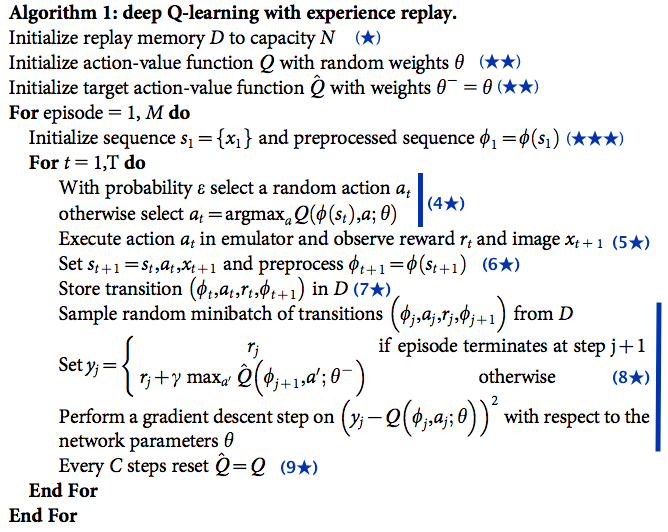

In [19]:
PATH = "pictures/"
Image(filename = PATH + "DQN2.png", width=600, height=600)



![](pictures/DQN2.png)

Go through the implementation in the cell below. You will find, that following every learning epoch of 200,000 frames (50,000 parameter updates), the agent is evaluated during 10,000 frames. Summaries are written to the logdir for tensorboard.

**I described the experiments I ran using this notebook [here](https://medium.com/@fabiograetz/tutorial-double-deep-q-learning-with-dueling-network-architectures-4c1b3fb7f756). Feel free to play with the notebook, implement changes and experiment with different environments. If you are able to improve it or gained experience with another Atari game, please leave a commet [here](https://medium.com/@fabiograetz/tutorial-double-deep-q-learning-with-dueling-network-architectures-4c1b3fb7f756), I'd love to know about it.**


In [20]:
def train():
    """Contains the training and evaluation loops"""
    my_replay_memory = ReplayMemory(size=MEMORY_SIZE, batch_size=BS)   # (★)
    update_networks = TargetNetworkUpdater(MAIN_DQN_VARS, TARGET_DQN_VARS)
    
    explore_exploit_sched = ExplorationExploitationScheduler(
        MAIN_DQN, atari.env.action_space.n, 
        replay_memory_start_size=REPLAY_MEMORY_START_SIZE, 
        max_frames=MAX_FRAMES)

    with tf.Session() as sess:
        sess.run(init)
        
        frame_number = 0
        rewards = []
        loss_list = []
        
        while frame_number < MAX_FRAMES:
            
            ########################
            ####### Training #######
            ########################
            epoch_frame = 0
            while epoch_frame < EVAL_FREQUENCY:
                terminal_life_lost = atari.reset(sess)
                episode_reward_sum = 0
                for _ in range(MAX_EPISODE_LENGTH):
                    # (4★)
                    action = explore_exploit_sched.get_action(sess, frame_number, atari.state)   
                    # (5★)
                    processed_new_frame, reward, terminal, terminal_life_lost, _ = atari.step(sess, action)  
                    frame_number += 1
                    epoch_frame += 1
                    episode_reward_sum += reward
                    
                    # Clip the reward
                    clipped_reward = clip_reward(reward)
                    
                    # (7★) Store transition in the replay memory
                    my_replay_memory.add_experience(action=action, 
                                                    frame=processed_new_frame[:, :, 0],
                                                    reward=clipped_reward, 
                                                    terminal=terminal_life_lost)   
                    
                    if frame_number % UPDATE_FREQ == 0 and frame_number > REPLAY_MEMORY_START_SIZE:
                        loss = learn(sess, my_replay_memory, MAIN_DQN, TARGET_DQN,
                                     BS, gamma = DISCOUNT_FACTOR) # (8★)
                        loss_list.append(loss)
                    if frame_number % NETW_UPDATE_FREQ == 0 and frame_number > REPLAY_MEMORY_START_SIZE:
                        update_networks(sess) # (9★)
                    
                    if terminal:
                        terminal = False
                        break

                rewards.append(episode_reward_sum)
                
                # Output the progress:
                if len(rewards) % 10 == 0:
                    # Scalar summaries for tensorboard
                    if frame_number > REPLAY_MEMORY_START_SIZE:
                        summ = sess.run(PERFORMANCE_SUMMARIES, 
                                        feed_dict={LOSS_PH:np.mean(loss_list), 
                                                   REWARD_PH:np.mean(rewards[-100:])})
                        
                        SUMM_WRITER.add_summary(summ, frame_number)
                        loss_list = []
                    # Histogramm summaries for tensorboard
                    summ_param = sess.run(PARAM_SUMMARIES)
                    SUMM_WRITER.add_summary(summ_param, frame_number)
                    
                    print(len(rewards), frame_number, np.mean(rewards[-100:]))
                    with open('rewards.dat', 'a') as reward_file:
                        print(len(rewards), frame_number, 
                              np.mean(rewards[-100:]), file=reward_file)
            
            ########################
            ###### Evaluation ######
            ########################
            terminal = True
            gif = True
            frames_for_gif = []
            eval_rewards = []
            evaluate_frame_number = 0
            
            for _ in range(EVAL_STEPS):
                if terminal:
                    terminal_life_lost = atari.reset(sess, evaluation=True)
                    episode_reward_sum = 0
                    terminal = False
               
                # Fire (action 1), when a life was lost or the game just started, 
                # so that the agent does not stand around doing nothing. When playing 
                # with other environments, you might want to change this...
                action = 1 if terminal_life_lost else explore_exploit_sched.get_action(sess, frame_number,
                                                                                       atari.state, 
                                                                                       evaluation=True)
                
                processed_new_frame, reward, terminal, terminal_life_lost, new_frame = atari.step(sess, action)
                evaluate_frame_number += 1
                episode_reward_sum += reward

                if gif: 
                    frames_for_gif.append(new_frame)
                if terminal:
                    eval_rewards.append(episode_reward_sum)
                    gif = False # Save only the first game of the evaluation as a gif
                     
            print("Evaluation score:\n", np.mean(eval_rewards))       
            try:
                generate_gif(frame_number, frames_for_gif, eval_rewards[0], PATH)
            except IndexError:
                print("No evaluation game finished")
            
            #Save the network parameters
            saver.save(sess, PATH+'/my_model', global_step=frame_number)
            frames_for_gif = []
            
            # Show the evaluation score in tensorboard
            summ = sess.run(EVAL_SCORE_SUMMARY, feed_dict={EVAL_SCORE_PH:np.mean(eval_rewards)})
            SUMM_WRITER.add_summary(summ, frame_number)
            with open('rewardsEval.dat', 'a') as eval_reward_file:
                print(frame_number, np.mean(eval_rewards), file=eval_reward_file)

## 10. Train it yourself

If you want to train the network yourself, set `TRAIN` to `True` in the first cell of this notebook.

Consider making your computer accessible remotely which I described in this blog post: [Accessing your Deep Learning station remotely and setting up wake on lan](https://medium.com/@fabiograetz/accessing-your-deep-learning-station-remotely-and-setting-up-wake-on-lan-1e708c50fdd8)

You can convert the notebook to a python script using `jupyter-nbconvert --to script DQN.ipynb` and then run it in a tmux session which I described here: [jupyter and tensorboard in tmux](https://medium.com/@fabiograetz/session/0df4a879-9184-498f-98e0-4104ba11f5a2-and-tensorboard-in-tmux-5e5d202a4fb6).
This has the advantage that you can detach from the tmux session and reattach to it remotely (from a laptop for example) in order to check on the agents progress. 

If you want to use tensorboard to monitor the networks improvements type `tensorboard --logdir=summaries` in a terminal in which the respective virtual environment is activated. Open a browser and go to http://localhost:6006. This works remotely as well.

In [21]:
if TRAIN:
    train()

## 9. Use a trained network

In [22]:
save_files_dict = {
    'BreakoutDeterministic-v4':("trained/breakout/", "my_model-15845555.meta"),
    'PongDeterministic-v4':("trained/pong/", "my_model-3217770.meta")
}

In [23]:
if not TRAIN:
    
    gif_path = "GIF/"
    os.makedirs(gif_path, exist_ok=True)

    trained_path, save_file = save_files_dict[ENV_NAME]

    explore_exploit_sched = ExplorationExploitationScheduler(
        MAIN_DQN, atari.env.action_space.n, 
        replay_memory_start_size=REPLAY_MEMORY_START_SIZE, 
        max_frames=MAX_FRAMES)
    
    with tf.Session() as sess:
        saver = tf.train.import_meta_graph(trained_path+save_file)
        saver.restore(sess,tf.train.latest_checkpoint(trained_path))
        frames_for_gif = []
        terminal_life_lost = atari.reset(sess, evaluation = True)
        episode_reward_sum = 0
        while True:
            #atari.env.render()
            action = 1 if terminal_life_lost else explore_exploit_sched.get_action(sess, 0, atari.state,  
                                                                                   evaluation = True)
            
            processed_new_frame, reward, terminal, terminal_life_lost, new_frame = atari.step(sess, action)
            episode_reward_sum += reward
            frames_for_gif.append(new_frame)
            if terminal == True:
                break
        
        atari.env.close()
        print("The total reward is {}".format(episode_reward_sum))
        print("Creating gif...")
        generate_gif(0, frames_for_gif, episode_reward_sum, gif_path)
        print("Gif created, check the folder {}".format(gif_path))

W0821 21:48:17.290949 139633102657280 deprecation.py:323] From /home/udocker/phoenix-worker/environments/python3/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


The total reward is 421.0
Creating gif...
Gif created, check the folder GIF/
